# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [1]:
# import libraries
from pyspark.sql import SparkSession
from pyspark.sql.types import StringType, IntegerType
from pyspark.sql.functions import sum as Fsum
from pyspark.sql.functions import * 
# isnan, count, when, col, desc, udf, col, sort_array, asc, avg
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression, DecisionTreeClassifier, RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import * 
from pyspark.ml.regression import LinearRegression
from pyspark.ml.tuning import *

import datetime

import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
def horizontalbar(x,y,chartcolor,xlabel,ylabel,title):
    """
    Reusable horizontal bar chart, with options for chart color, label and title baked in.
    This needs matplotlib and refers to it as plt
    please have this import - import matplotlib as plt
    """
    plt.style.use('ggplot')
    fig,ax = plt.subplots()
    y_pos = np.arange(len(y))
    ax.barh(y_pos,y,color=chartcolor)
    ax.set_yticks(y_pos)
    ax.set_yticklabels(x)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    for i, v in enumerate(y):
        ax.text(v + 50, i + .0015, str(v), color='black', fontweight='bold')
    plt.show()

In [3]:
# create a Spark session
spark = SparkSession \
    .builder \
    .appName("CapstoneProject") \
    .getOrCreate()

In [4]:
# Get configuration
spark.sparkContext.getConf().getAll()

[('spark.driver.port', '44345'),
 ('spark.app.name', 'CapstoneProject'),
 ('spark.rdd.compress', 'True'),
 ('spark.serializer.objectStreamReset', '100'),
 ('spark.master', 'local[*]'),
 ('spark.app.id', 'local-1606258178558'),
 ('spark.executor.id', 'driver'),
 ('spark.submit.deployMode', 'client'),
 ('spark.ui.showConsoleProgress', 'true'),
 ('spark.driver.host', 'ed8bfe059e08')]

In [5]:
spark

# Project Overview

This project seeks to perform data analysis on Sparkify Data Set, to identify the churning patterns and behaviours using Spark and PySpark. 

## Problem Domain 

Internet app based customer churing analysis

## Problem Statement

The online music streaming service provider, "Sparkify" facing a problem on losing it is paid subscribers and in this project we are looking to develop machine leanring models by following CRISP-DM process

## Metrics Employed

We will pursue accuracy score and F1 score for our machine learning models as a evaluation metric. We want to identify those who are likely to drop out from the subscription service and potentially offer them incentives (which are out of scope for this project) to retain the subscriber and would like to minimize the number of incentive offers sent at the same time maximizing the revenue by sending incentives to right subscriber (which is out of scope for this project).

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [4]:
path = "mini_sparkify_event_data.json"
sparkify = spark.read.json(path)

In [7]:
sparkify.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



### Data Exploration

In [5]:
sparkify.describe("auth").show()

+-------+----------+
|summary|      auth|
+-------+----------+
|  count|    286500|
|   mean|      null|
| stddev|      null|
|    min| Cancelled|
|    max|Logged Out|
+-------+----------+



In [9]:
sparkify.describe("sessionId").show()

+-------+-----------------+
|summary|        sessionId|
+-------+-----------------+
|  count|           286500|
|   mean|1041.526554973822|
| stddev|726.7762634630741|
|    min|                1|
|    max|             2474|
+-------+-----------------+



In [10]:
sparkify.select("page").dropDuplicates().sort("page").show()

+--------------------+
|                page|
+--------------------+
|               About|
|          Add Friend|
|     Add to Playlist|
|              Cancel|
|Cancellation Conf...|
|           Downgrade|
|               Error|
|                Help|
|                Home|
|               Login|
|              Logout|
|            NextSong|
|            Register|
|         Roll Advert|
|       Save Settings|
|            Settings|
|    Submit Downgrade|
| Submit Registration|
|      Submit Upgrade|
|         Thumbs Down|
+--------------------+
only showing top 20 rows



### Data Preprocessing 
Drop Rows with Missing Values

In [5]:
df_valid = sparkify.dropna(how = "any", subset = ["userId", "sessionId"])

In [6]:
df_valid = df_valid.filter(df_valid["userId"] != "")

In [7]:
df_valid = df_valid.sort(["userId","ts","sessionId"]).withColumn("pk",monotonically_increasing_id())

In [24]:
# Count the total number of rows
df_valid.count()

278154

In [10]:
# Calculate number of missing values for each column - suprisingly there are none

#sparkify.select([count(when(isnan(c), c)).alias(c) for c in sparkify.columns]).show()

In [ ]:
# to create data cleaning and pre-processing, I am looking to use SparkSQL to perform the analysis

In [8]:
sparkify.createOrReplaceTempView("sparkifytable")

In [ ]:
# Counting the missing values in each column in not as simple as one would expect in PySpark

In [12]:
#spark.sql("select sum(case when artist is null then 1 else 0 end) as artistnull from sparkifytable \
#                where artist is null").collect()

columnlist = sparkify.columns

for i in columnlist:
    a = spark.sql("select sum(case when {} is null then 1 else 0 end) as {}_missing from sparkifytable \
                where {} is null".format(i,i,i)).collect()
    print(i,a)

artist [Row(artist_missing=58392)]
auth [Row(auth_missing=None)]
firstName [Row(firstName_missing=8346)]
gender [Row(gender_missing=8346)]
itemInSession [Row(itemInSession_missing=None)]
lastName [Row(lastName_missing=8346)]
length [Row(length_missing=58392)]
level [Row(level_missing=None)]
location [Row(location_missing=8346)]
method [Row(method_missing=None)]
page [Row(page_missing=None)]
registration [Row(registration_missing=8346)]
sessionId [Row(sessionId_missing=None)]
song [Row(song_missing=58392)]
status [Row(status_missing=None)]
ts [Row(ts_missing=None)]
userAgent [Row(userAgent_missing=8346)]
userId [Row(userId_missing=None)]


As we see from the above table, there are 8,346 rows that contains no user information - no first name, last name, gender, registration, location and userAgent. These rows are not going to be helpful when performing churn analysis and we can discard these.

# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

### Data Vizualization
Let us have a detailed look at the categorical variables

In [15]:
usertype = spark.sql("Select level, count(*) from sparkifytable group by level").show()
usertype

+-----+--------+
|level|count(1)|
+-----+--------+
| free|   58338|
| paid|  228162|
+-----+--------+



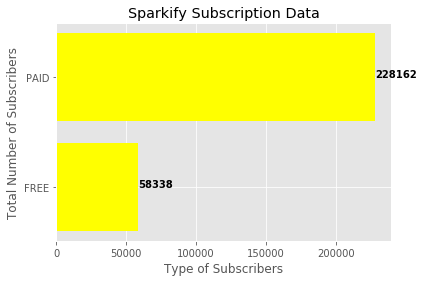

In [16]:
horizontalbar(
    x=['FREE','PAID'], 
    y=[58338, 228162],
    chartcolor='yellow',
    xlabel='Type of Subscribers', 
    ylabel='Total Number of Subscribers',
    title='Sparkify Subscription Data')

In [17]:
location = sparkify.groupBy("location").count().toPandas().sort_values(by="count", ascending=False)["location"].head(16).tolist()
count = sparkify.groupBy("location").count().toPandas().sort_values(by="count", ascending=False)["count"].head(16).tolist()

In [18]:
location.pop(4)
count.pop(4)

8346

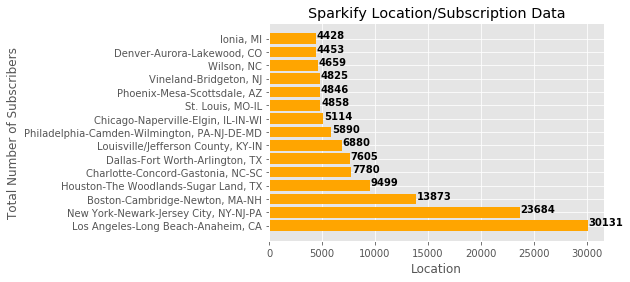

In [19]:
horizontalbar(
    x=location, 
    y=count,
    chartcolor='orange',
    xlabel='Location', 
    ylabel='Total Number of Subscribers',
    title='Sparkify Location/Subscription Data')

Some analysis on authentication and page actions needed to be counted for each unique users as aggregating on duplication might be misleading.

In [20]:
sparkify.groupBy("auth").agg(countDistinct("userId")).show()

+----------+----------------------+
|      auth|count(DISTINCT userId)|
+----------+----------------------+
|Logged Out|                     1|
| Cancelled|                    52|
|     Guest|                     1|
| Logged In|                   225|
+----------+----------------------+



In [19]:
sparkify.agg(countDistinct("UserId")).show()

+----------------------+
|count(DISTINCT UserId)|
+----------------------+
|                   226|
+----------------------+



Our sample dataset has 226 users, out of which 52 have cancelled their subscription.

In [20]:
round(52/226*100,2)

23.01

Current churn rate is 23.01%

In [21]:
sparkify.groupBy("page").agg(countDistinct("UserId")).toPandas()

,page,count(DISTINCT UserId)
0,Cancel,52
1,Submit Downgrade,49
2,Thumbs Down,203
3,Home,224
4,Downgrade,154
5,Roll Advert,207
6,Logout,213
7,Save Settings,132
8,Cancellation Confirmation,52
9,About,156


As we see from above, there is a lot of activities going on here, in addition to cancellation confirmation, which is our key variable to determine churning rate. Some key activites that may help us iddentify the pattern of behavior are, downgrade, upgrade, next song, add to playlist, add to friend, thumbsdown, thumbs up, etc... 

We will look more closely to look at these behaviours based on churned or retained subscribers, here on

In [22]:
sparkify.groupBy("gender").agg(countDistinct("UserId")).show()

+------+----------------------+
|gender|count(DISTINCT UserId)|
+------+----------------------+
|     F|                   104|
|  null|                     1|
|     M|                   121|
+------+----------------------+



In [9]:
churnUserId = df_valid.filter(df_valid.page == "Cancellation Confirmation").select('UserId').distinct().toPandas()
churnUserId = churnUserId.UserId.tolist()
df_valid = df_valid.withColumn('ChurnedUser', when(df_valid.userId.isin(churnUserId),1).otherwise(0))

In [31]:
df_valid.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)
 |-- pk: long (nullable = false)
 |-- ChurnedUser: integer (nullable = false)



In [11]:
# transform the data to each user
df_userview = df_valid.groupby(["userId"]).pivot("page").count().fillna(0)
df_userview = df_userview.toPandas()

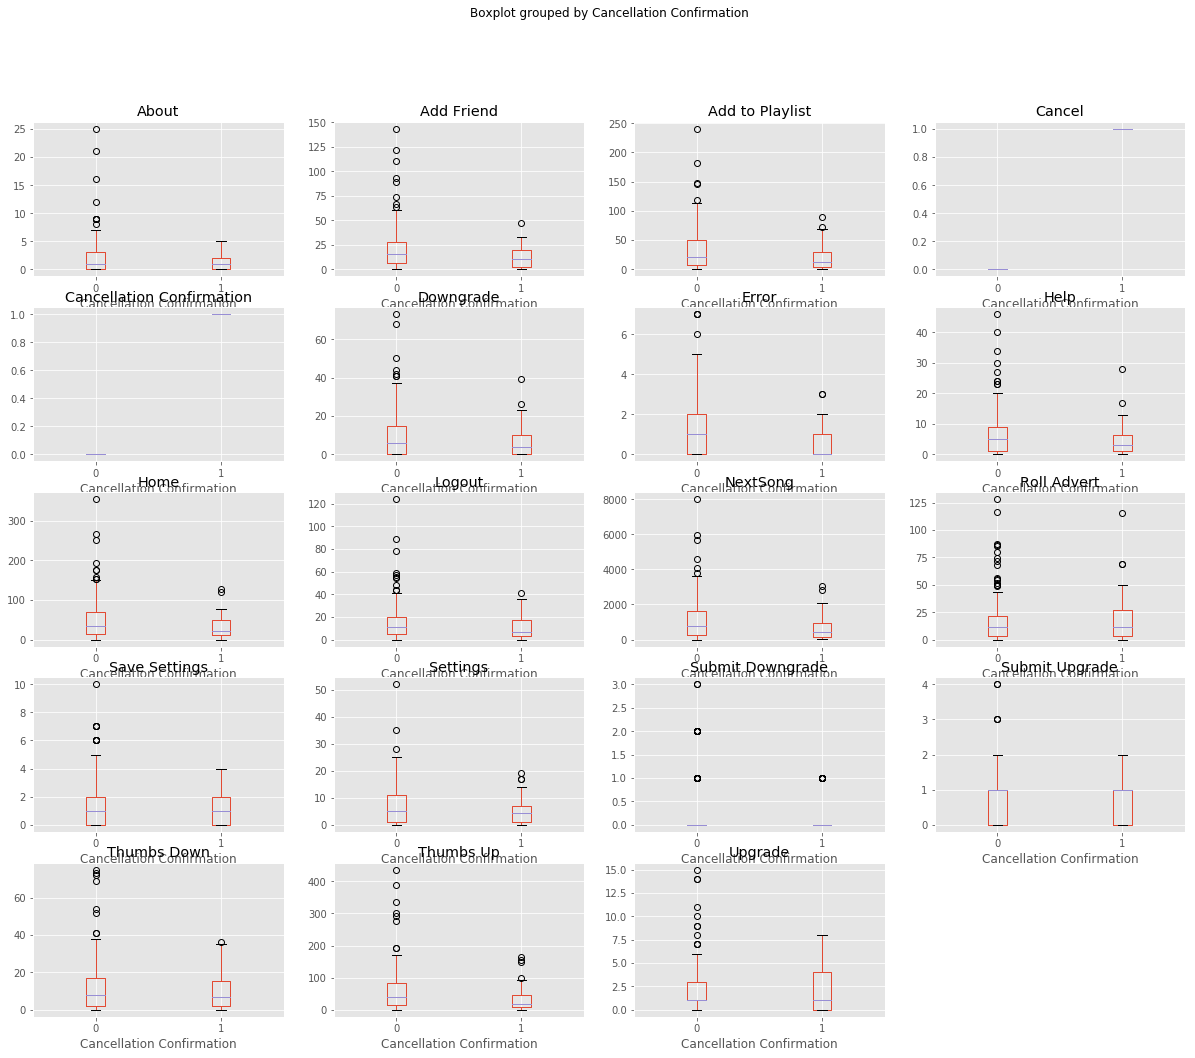

In [33]:
# create box and whisker plot against churn variable -- cancellation confirmation
fig = plt.figure(figsize=(20,20))
for i in range(1,len(df_userview.columns)):
    df_userview.boxplot(df_userview.columns[i],
                             ax=fig.add_subplot(6,4,i),
                             by="Cancellation Confirmation")

### Exploratory Data Analysis Conclusion

As we see above, in the box and whisker plots, subscribers who leave the sparkify service, tend to participate less in "add to playlist" event -- they do not seem to add as many songs in a playlist when compared to the ones who remain as loyal subscriber to sparkify service.
Subscribers who leave this service also tend to add less friends when compared to ones who remain as loyal subscribers.
Subscribers who leave this service are less likely tend to click to go to next songs when compared to subscribers who continue to be a loyal subscriber.
Subscribers who leave this service tend to upgrade more than compared to subscribers who remain as loyal subscribers to sparkify streaming service.
Similar patterns are also seem to be prevalent in thumbs up and thumbs down category espescially in thumbs up event.

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

### Data Preprocessing and Model Implementation 
From our EDA, we would like to consider, length of songs played, average length of played songs, number of days active for all subscribers during free and paid levels of subscription, total number of sessions

In [11]:
# total length of the song
songlength = df_valid.where(df_valid.song != 'null').groupby('userId') \
.agg({'length':'sum'}) \
.orderBy('userId') \
.withColumnRenamed("sum(length)", "songlength")

In [12]:
# average length of the song
songlengthavg = df_valid.where(df_valid.song != 'null').groupby('userId') \
.agg({'length':'avg'}) \
.orderBy('userId') \
.withColumnRenamed("avg(length)", "songlengthavg")

In [13]:
# number of songs
songcount = df_valid.where(df_valid.song != 'null').groupby('userId') \
.agg({'song':'count'}) \
.orderBy('userId') \
.withColumnRenamed("count(song)", "songcount")

In [14]:
# number of sessions
numsessions = df_valid.select(['userId','sessionId']) \
.distinct() \
.groupby('userId') \
.count() \
.orderBy('userId') \
.withColumnRenamed('count','numsessions')

In [15]:
# Add friend event
friends = df_valid.where(df_valid.page == "Add Friend") \
.groupby('userId').agg({'page':'count'})\
.orderBy('userId')\
.withColumnRenamed("count(page)","friendcount")
friends = friends.replace(float('nan'), None)

In [16]:
# Add Playlist event
playlist = df_valid.where(df_valid.page == "Add to Playlist") \
.groupby('userId').agg({'page':'count'})\
.orderBy('userId')\
.withColumnRenamed("count(page)","addtoplaylist")

In [17]:
# churn data
label = df_valid.groupby('userId').agg({'ChurnedUser':'first'}).orderBy('userId')\
.withColumnRenamed('first(ChurnedUser)','label')

In [18]:
# number of days active for users
time = 60*60*24*1000
min_ts = df_valid.select(['userId','ts']).groupby('userId').min('ts')
max_ts = df_valid.select(['userId','ts']).groupby('userId').max('ts')
days_active = min_ts.join(max_ts,on='userId')
days_active = days_active.withColumn('days_active',(col('max(ts)')-col('min(ts)'))/time)
days_active = days_active.select(['userId','days_active']).orderBy('userId')

In [157]:
# average length of song played
#nextsong = sparkify.filter(sparkify.page == 'NextSong')
#songlength = nextsong.groupby(nextsong.userId).agg(Fsum(nextsong.length)).collect()

# Machine Learning Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

In [19]:
modelfile = (songcount
             .join(days_active, 'userId','full')
             .join(friends, 'userId', 'full')
             .join(numsessions, 'userId','full')
             .join(playlist, 'userId','full')
             .join(label,'userId','full'))
modelfile = modelfile.fillna({'friendcount':0})
modelfile = modelfile.fillna({'addtoplaylist':0})

In [49]:
modelfile.toPandas()

,userId,songcount,days_active,friendcount,numsessions,addtoplaylist,label
0,100010,275,44.217801,4,7,7,0
1,200002,387,45.496806,4,6,8,0
2,125,8,0.020532,0,1,0,1
3,124,4079,59.996944,74,29,118,0
4,51,2111,15.779398,28,10,52,1
5,7,150,50.784051,1,7,5,0
6,15,1914,54.773183,31,15,59,0
7,54,2841,42.797199,33,37,72,1
8,155,820,25.827836,11,6,24,0
9,100014,257,41.244363,6,6,7,1


## Baseline Model

In [21]:
# Preparing featuers data without the userid and predictor variable
features = modelfile.drop('label','userId').schema.names

# Transform multiple columns into one column called Features
vector_assembler = VectorAssembler(inputCols=features,outputCol = 'Features')

# transform the input data set with the features 
modelinput = vector_assembler.transform(modelfile)

# Scale and normalize the features 
Scaler1 = StandardScaler(withMean=True,withStd=True,inputCol='Features',outputCol='ScaledFeatures')
FeatureScaler1Fit = Scaler1.fit(modelinput)
ScaledInput1 = FeatureScaler1Fit.transform(modelinput)

# Renaming the variables so the model methods recognize the code
modeldata = ScaledInput1.select(ScaledInput1.label.alias('label'),ScaledInput1.ScaledFeatures.alias('features'))

# spliting the data into training and testing data sets
train, test = modeldata.randomSplit([0.75,0.25])

In [22]:
# Base Logit - initialize the logistic regression with maxium of 10 iterations
lr = LogisticRegression(maxIter=10)

# define the evalutator with metric
f1_evaluator=MulticlassClassificationEvaluator(metricName='f1')

# no parametres passed on the grid builder 
paramGrid = ParamGridBuilder().build()

# execute the base model with 3-fold cross validation
crossvalidation_baselr = CrossValidator(estimator=lr,
                                        evaluator=f1_evaluator,
                                        estimatorParamMaps=paramGrid,
                                        numFolds=3)

In [23]:
# train the model
baselr = crossvalidation_baselr.fit(train)

# apply the model to test data set
baselrtest = baselr.transform(test)

# initialize the evaluator to get the accuracy and F1-score
evaluator=MulticlassClassificationEvaluator(predictionCol='prediction')

# print the scores
print('Accuracy:{}'.format(evaluator.evaluate(baselrtest,{evaluator.metricName: "accuracy"})))
print('F1 Score:{}'.format(evaluator.evaluate(baselrtest,{evaluator.metricName: "f1"})))

Accuracy:0.76
F1 Score:0.76


In [28]:
baselr.bestModel

LogisticRegressionModel: uid = LogisticRegression_806c81d1262e, numClasses = 2, numFeatures = 5

In [24]:
# decision tree classifier
dtc = DecisionTreeClassifier()

# initialize the evalutor 
f1_evaluator=MulticlassClassificationEvaluator(metricName='f1')

# no parameters passed
dtc_parameterGrid = ParamGridBuilder().build()

# base decision tree model wiht 3-fold cross validation
dtc_crossval = CrossValidator(estimator = dtc, estimatorParamMaps=dtc_parameterGrid, 
                             evaluator=f1_evaluator,
                             numFolds=3)

In [25]:
# train the model
basedtc = dtc_crossval.fit(train)

# apply the model to test data set
basedtctest = basedtc.transform(test)

# initialize the evaluator for accuracy and F1 metric
evaluator=MulticlassClassificationEvaluator(predictionCol='prediction')

# print the scores 
print('Accuracy:{}'.format(evaluator.evaluate(basedtctest,{evaluator.metricName: "accuracy"})))
print('F1 Score:{}'.format(evaluator.evaluate(basedtctest,{evaluator.metricName: "f1"})))

Accuracy:0.82
F1 Score:0.7905315379163714


### Summary

The base models yield the following information:

For logistic regression, the accuracy is 0.76 and f1 score is 0.76
For decision tree classifier, the accuracy is 0.82 and f1 score is 0.79

This could be result of model over fitting as base models with very high accuracy need to be reviewed.

In the following section, I employ hyper parameter tuning and run the models again

In [29]:
# Logistic Regression
lr = LogisticRegression(maxIter=10)
pipeline_lr = Pipeline(stages=[lr])
f1_evaluator=MulticlassClassificationEvaluator(metricName='f1')

# create parameter grids
lr_parameterGrid = (ParamGridBuilder().addGrid(lr.regParam,[0.0,0.1]).build())

# cross validation 3-step
lr_crossval = CrossValidator(estimator=pipeline_lr, 
                            estimatorParamMaps=lr_parameterGrid,
                            evaluator=f1_evaluator,
                            numFolds=3)

In [17]:
## Modeling Methodology
# splitting the data into training test and testing set 
#train, test = modelfile.randomSplit([0.8,0.2])

# vectorize the features by dropping the variables not needed for prediction - outcome variable and userID as well
#features = train.drop('label','userId').schema.names
#vector_assembler = VectorAssembler(inputCols=features,outputCol = 'Features')

# we are scaling the features to overcome any variable that has a larger scale overpowering the model
#scale = MinMaxScaler(inputCol='Features',outputCol='Scaler')

In [30]:
# decision tree classifier
dtc = DecisionTreeClassifier()
pipeline_dtc = Pipeline(stages=[dtc])

# creating parameter grids
dtc_parameterGrid = ParamGridBuilder().addGrid(dtc.maxDepth,[1,2]).build()

# cross validation 3-step
dtc_crossval = CrossValidator(estimator = pipeline_dtc, 
                              estimatorParamMaps=dtc_parameterGrid, 
                             evaluator=f1_evaluator,
                             numFolds=3)

In [18]:
# Logistic Regression

#lr = LogisticRegression(maxIter=10,featuresCol='Scaler',labelCol='label')
#pipeline_lr = Pipeline(stages=[vector_assembler, scale, lr])

# create parameter grids
#lr_parameterGrid = (ParamGridBuilder().addGrid(lr.regParam,[0.0,0.1]).build())

# cross validation 3-step
#lr_crossval = CrossValidator(estimator=pipeline_lr, estimatorParamMaps=lr_parameterGrid, evaluator=MulticlassClassificationEvaluator(),
# numFolds=2)

In [18]:
# Logistic Regression

#lr = LogisticRegression(featuresCol='Scaler',labelCol='label')
#pipeline_lr = Pipeline(stages=[vector_assembler, scale, lr])

# create parameter grids
#lr_parameterGrid = (ParamGridBuilder().addGrid(lr.regParam,[0.0,0.1]).build())

# cross validation 3-step
#lr_crossval = CrossValidator(estimator=pipeline_lr, 
#                            estimatorParamMaps=lr_parameterGrid,
#                            evaluator=MulticlassClassificationEvaluator(),
#                            numFolds=3)

In [38]:
# decision tree classifier

#dtc = DecisionTreeClassifier(featuresCol='Scaler', labelCol='label')
#pipeline_dtc = Pipeline(stages=[vector_assembler, scale, dtc])

# creating parameter grids
#dtc_parameterGrid = ParamGridBuilder().addGrid(dtc.maxDepth,[1,2]).build()

# cross validation 3-step
#dtc_crossval = CrossValidator(estimator = pipeline_dtc, estimatorParamMaps=dtc_parameterGrid, 
#                             evaluator=MulticlassClassificationEvaluator(),
#                             numFolds=3)

## Model Evaluation

Keeping our machine learning analysis modest, we are running logistic regression and decision tree classifier on our sparkify subscribers data set

Model coefficients for logistic regression and number of trees for decision trees

In [35]:
# Py4jError troubleshooting - do not use if the model trains successfully
spark.sparkContext.setCheckpointDir('checkpoint')
train.checkpoint()
#train.explain(extended=True)
train = spark.createDataFrame(train.rdd, schema=train.schema)

In [39]:
dtc_train = pipeline_dtc.fit(train)

In [32]:
# train the model
trained_lr = lr_crossval.fit(train)

In [37]:
# get the hyperpar
bestModellr = trained_lr.bestModel
#print(bestModellr.getRegParam())
#print(bestModellr.getMaxIter())
bestModellr.stages[-1]
#bestModellr._java_obj.getRegParam()

LogisticRegressionModel: uid = LogisticRegression_7fccd5df6d7c, numClasses = 2, numFeatures = 5

In [33]:
#bestModeldtc = dtc_train.bestModel
dtc_train1 = dtc_crossval.fit(train)

In [39]:
dtc_train1.bestModel.stages[-1]

DecisionTreeClassificationModel (uid=DecisionTreeClassifier_c2f0dd23b42e) of depth 2 with 5 nodes

## Model Validation and Metrics Evaluation

We will be looking at accuracy metric and f1-score for both these algorithms to evaluate their effectiveness.

In [35]:
# validation logistic regresssion

logisticregression = trained_lr.transform(test)
lr_score = evaluator.evaluate(logisticregression)
print(lr_score)
print('Accuracy: {}'.format(evaluator.evaluate(logisticregression, {evaluator.metricName: 'accuracy'})))
print('f1 score: {}'.format(evaluator.evaluate(logisticregression, {evaluator.metricName: 'f1'})))

0.76
Accuracy: 0.76
f1 score: 0.76


In [36]:
# validation decision tree classifier

decisiontree = dtc_train1.transform(test)
dtc_score = evaluator.evaluate(decisiontree)
print(dtc_score)
print('Accuracy: {}'.format(evaluator.evaluate(decisiontree, {evaluator.metricName: 'accuracy'})))
print('f1 score: {}'.format(evaluator.evaluate(decisiontree, {evaluator.metricName: 'f1'})))

0.7595238095238095
Accuracy: 0.8
f1 score: 0.7595238095238095


In [47]:
spark

# Results

## Modeling and Justification 

The logistic regression yields an accuracy score of 0.76 and f1 score of 0.76 for our churning model.

The decision tree classifier yields an accuracy score of 0.8 and f1 score of 0.7595238095238095. This metric is quite impressive as having developed predictive models in my previous assignments with real world data with variations within data set that is out of control, any accuracy score above 60% is considered a good metric to me.

Accuracy metric is measure of all correctly identified cases. In this case the model is 80% accurate. However the remaining percent actually contains subscribers that are going to leave our music streaming service without being identified. This can be a high cost for the organization and we should try to minimize the false negatives. This is where we use F1 Score.

F1 score gives us better measure of incorrectly classifeid cases than the accuracy metric. F1 is used when false positives and false negatives are very important. Missing a customer who is about to leave the service can be a high cost and the reason why we need to look at F1 score and weigh more than accuracy.

Higher F1-score is a healthy indicator of the predictive model. In this context, F1-score of 0.7595 would mean that the remaining percent would contribute to false positive and false negative circumstances where a subscriber who is leaving the service are not being found and a subscriber who is loyal to service is being marked as at risk of leaving. Both of these can have a effect on Sparkify's revenue

Lack of sample size is concerning and potentially effectiveness will be more obvious if the number of users were to be in few thousands.

# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.

# Conclusion

In this capstone project, I have imported log files of an app from a fictitious company, Sparkify, performed data cleaning, identified missing values and treated them, performed univariate and bivariate analysis, data vizualizations, fit a predictive model, tuned the hyper parameters to obtain a better fit and presented the results. 

I found the JSON documents part of it, interesting and enjoyable as I have worked with JSON documents in one of my previous projects, and found the technical setup difficult; the spark cluster, seem to have memory limitations and number of nodes running the background.


### Reflection and Improvement

As someone who has played with Apache Spark during Scala days, it was a pleasure to discover the PySpark matured into a proper package with full support for data frames and growing traction for PySpark ML library. 

Also, at the same time, I understand the pain points of running relatively small batch of data into a distributed system. It is going to be ridicule to use RDD for a data set that has little over 250 rows with few columns. Nevertheless, it has been a great practice for me and I remain thanking for that.

The data set is somewhat cleaned and relatively less messy. The behavior of churners (subscribers) does not seem relatively trivial -- one would imagine someone spends less time on the streaming service, does not add more friends or songs to play list would likely to dropout however we have good mix of data that has subscribers who appear to be loyal to service and yet have decided to downgrade or execute the event "cancellation confirmation" so this was interesting.

There is also the concept of system tuning or troubleshooting the resource allocation (job scheduling, memory reallocation, etc...) from the system level that would play a crucial role in duration it takes for each job to run and data to persist.